## Importing Libraries

In [ ]:
!pip3 install pubchempy
!pip3 install rdkit

  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=193a67ba8b745df3209db518636c0aa51289f95ae76470e745ff59ee29556ce8
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 25.5 MB/s eta 0:00:00


In [ ]:
import pubchempy as pcp
import pandas as pd
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn import tree
import graphviz
from sklearn.model_selection import GridSearchCV
from imblearn.metrics import geometric_mean_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from rdkit import Chem
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import copy
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras

# Apply the default theme
sns.set_theme()

warnings.filterwarnings("ignore")

## Getting Data Using APIs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data-3.csv')

In [ ]:
print("Number of inactive cases is: ", df.where(df["HIT CALL"] == "Inactive").count()[0])
print("Number of active cases is: ", df.where(df["HIT CALL"] == "Active").count()[0])

Number of inactive cases is:  193
Number of active cases is:  443


In [ ]:
df.isnull().any().any()

False

## Building Models

### Cleaning Data

In [ ]:
df = df.drop(columns=['Unnamed: 0', 'PREFERRED NAME', 'compounds', 'canonical_smiles'])

In [ ]:
df.head().shape

(5, 1979)

In [ ]:
# Assuming you have a dataframe named 'df'
# First, identify columns with string type
string_columns = df.select_dtypes(include='object').columns.tolist()
string_columns.remove("HIT CALL")

# Then, drop those columns
std_df = df.drop(columns=string_columns)

In [ ]:
std_df["HIT CALL"] = std_df["HIT CALL"].replace("Active", 1)
std_df["HIT CALL"] = std_df["HIT CALL"].replace("Inactive", 0)

In [ ]:
std_df_32 = std_df.astype(np.float32)

In [ ]:
np.isinf(std_df_32).any().any()

True

In [ ]:
np.isnan(std_df_32).any().any()

False

In [ ]:
std_df_32.replace([np.inf, -np.inf], np.nan, inplace=True)
std_df_32.dropna(inplace=True)

In [ ]:
std_df_32 = std_df_32.loc[:, std_df_32.std() > 0.1]

In [ ]:
features = list(std_df_32.columns)
features.remove('HIT CALL')

In [ ]:
X = std_df_32[features]
y = std_df_32["HIT CALL"]

In [ ]:
X.head().shape

(5, 790)

In [ ]:
# Drop highly correlated features

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# drop the columns
X.drop(columns=to_drop, inplace=True)

In [ ]:
X.head().shape

(5, 446)

In [ ]:
std = X.std()
mask = std < 0.1
X.drop(columns=std[mask].index, inplace=True)

In [ ]:
X.head().shape

(5, 446)

### Standardization

In [ ]:
scaler = StandardScaler()
stand_X = copy.deepcopy(X)
stand_X = scaler.fit_transform(X)
stand_X = pd.DataFrame(stand_X, index=X.index, columns=X.columns)

### Train Test Split

In [ ]:
stand_X_train, stand_X_test, stand_y_train, stand_y_test = train_test_split(stand_X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Oversampling

In [ ]:
smote = SMOTE(sampling_strategy='minority')
stand_X_train_sm, stand_y_train_sm = smote.fit_resample(stand_X_train, stand_y_train)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print(y_train_sm.value_counts())

1.0    354
0.0    354
Name: HIT CALL, dtype: int64


### Evaluation Methods

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

In [ ]:
def sensivity(tp, fp, tn, fn):
  return 100*(tp / (tp+fn))

def specificity(tp, fp, tn, fn):
  return 100*(tn / (tn+fp))

def PPV(tp, fp, tn, fn):
  return 100*(tp / (tp+fp))

def NPV(tp, fp, tn, fn):
  return 100*(tn / (tn+fn))

def BA(true, pred):
  return balanced_accuracy_score(true, pred)

def AUC(true, pred):
  return roc_auc_score(true, pred)

from math import sqrt
def mcc(tp, fp, tn, fn):
    x = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return ((tp * tn) - (fp * fn)) / sqrt(x)

In [ ]:
def create_record(y_pred_train, y_pred_test, name, y_test=y_test, y_train=y_train, selected_features=[]):
  tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
  tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()

  mcc_train = matthews_corrcoef(y_train, y_pred_train)
  mcc_test = matthews_corrcoef(y_test, y_pred_test)
  sensivity_train = sensivity(tp_train, fp_train, tn_train, fn_train)
  sensivity_test = sensivity(tp_test, fp_test, tn_test, fn_test)
  specificity_train = specificity(tp_train, fp_train, tn_train, fn_train)
  specificity_test = specificity(tp_test, fp_test, tn_test, fn_test)
  PPV_train = PPV(tp_train, fp_train, tn_train, fn_train)
  PPV_test = PPV(tp_test, fp_test, tn_test, fn_test)
  NPV_train = NPV(tp_train, fp_train, tn_train, fn_train)
  NPV_test = NPV(tp_test, fp_test, tn_test, fn_test)
  BA_train = BA(y_train, y_pred_train)
  BA_test = BA(y_test, y_pred_test)
  AUC_train = AUC(y_train, y_pred_train)
  AUC_test = AUC(y_test, y_pred_test)

  record = {'Name': name,
            'MCC_train': "{:.2f}".format(mcc_train), 'MCC_test': "{:.2f}".format(mcc_test),
            'sensivity_train': "{:.2f}".format(sensivity_train), 'sensivity_test': "{:.2f}".format(sensivity_test),
            'specificity_train': "{:.2f}".format(specificity_train), 'specificity_test': "{:.2f}".format(specificity_test),
            'positive_predictive_value_train': "{:.2f}".format(PPV_train), 'positive_predictive_value_test': "{:.2f}".format(PPV_test),
            'negative_predictive_value_train': "{:.2f}".format(NPV_train), 'negative_predictive_value_test': "{:.2f}".format(NPV_test),
            'balanced_accuracy_train': "{:.2f}".format(BA_train), 'balanced_accuracy_test': "{:.2f}".format(BA_test),
            'AUC_train': "{:.2f}".format(AUC_train), 'AUC_test': "{:.2f}".format(AUC_test),
            'TP_test': tp_test, 'FP_test': fp_test, 'TN_test': tn_test, 'FN_test': fn_test,
            'TP_train': tp_train, 'FP_train': fp_train, 'TN_train': tn_train, 'FN_train': fn_train,
            'Selected_Features': selected_features, 'Size':len(selected_features)}

  return record

In [ ]:
results = pd.DataFrame(columns=['Name', 'MCC_train', 'MCC_test', 'sensivity_train', 'sensivity_test', 'specificity_train',
                                'specificity_test', 'positive_predictive_value_train', 'positive_predictive_value_test',
                                'negative_predictive_value_train', 'negative_predictive_value_test', 'balanced_accuracy_train',
                                'balanced_accuracy_test', 'AUC_train', 'AUC_test', 'TP_test', 'FP_test', 'TN_test',
                                'FN_test', 'TP_train', 'FP_train', 'TN_train', 'FN_train',
                                'Selected_Features', 'Size'])

### Feature Selection

In [ ]:
tree_clf = ExtraTreesClassifier()
tree_clf = tree_clf.fit(stand_X_train, stand_y_train)

In [ ]:
tree_feature_selection = pd.DataFrame({"features": stand_X_train.columns.to_list(), "Importance": tree_clf.feature_importances_.tolist()}).sort_values(by="Importance", ascending=False)
selected_features = tree_feature_selection.head(100)['features'].tolist()
# selected_features

In [ ]:
selected_features_ = []
selected_features_.append(tree_feature_selection.head(20)['features'].tolist())
selected_features_.append(tree_feature_selection.head(50)['features'].tolist())
selected_features_.append(tree_feature_selection.head(150)['features'].tolist())
selected_features_.append(tree_feature_selection.head(300)['features'].tolist())
selected_features_.append(tree_feature_selection.tail(300)['features'].tolist())
selected_features_.append(tree_feature_selection.tail(150)['features'].tolist())
selected_features_.append(tree_feature_selection.tail(50)['features'].tolist())
selected_features_.append(tree_feature_selection.tail(20)['features'].tolist())

### GradientBoosting

In [ ]:
import xgboost as xgb

def GradientBoostingClassifier_function(selected_features, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, name="Gradient Boosting"):
  params = {
      # 'n_estimators': 50,
      'max_depth': 30,
      'learning_rate': 0.4,
      'objective': 'binary:logistic',
      'reg_lambda': 10,
      'random_state': 42
  }

  # Convert your data to XGBoost's DMatrix format
  dtrain = xgb.DMatrix(X_train[selected_features], label=y_train)

  # Perform cross-validation
  cv_results = xgb.cv(
      params=params,
      dtrain=dtrain,
      num_boost_round=1000,
      nfold=5,  # Number of folds
      metrics='error',  # You can change this to other metrics like 'logloss'
      early_stopping_rounds=10,
      verbose_eval=False,
      seed=42
  )

  # Retrieve the best number of boosting rounds
  best_num_boost_rounds = len(cv_results)

  # Train the final model using the best number of boosting rounds
  final_model = xgb.train(
      params=params,
      dtrain=dtrain,
      num_boost_round=best_num_boost_rounds
  )

  # Make predictions on the test set
  dtest = xgb.DMatrix(X_test[selected_features])
  dtrain = xgb.DMatrix(X_train[selected_features])
  y_pred = final_model.predict(dtest)
  y_pred_train = final_model.predict(dtrain)

  # Convert predictions to binary values
  y_pred_binary = np.round(y_pred)
  y_pred_binary_train = np.round(y_pred_train)

  # Calculate accuracy on the test set
  # accuracy = accuracy_score(y_test, y_pred_binary)
  # print("Test Accuracy:", accuracy)
  balanced_accuracy = BA(y_test, y_pred_binary)

  print("BA score on the test set for GradientBoostingClassifier with {} features is is: {:.2f}".format(len(selected_features), balanced_accuracy))
  # print("MCC score on the train set for GradientBoostingClassifier is: {:.2f}".format(matthews_corrcoef(y_train, y_pred_binary_train)))

  results.loc[len(results)] = create_record(y_pred_train>0.5, y_pred_binary>0.5, name, y_test, y_train, selected_features)
  return final_model

In [ ]:
# print("Test Accuracy:", accuracy)
for i in selected_features_[:4]:
  GradientBoostingClassifier_function(i)

BA score on the test set for GradientBoostingClassifier with 20 features is is: 0.72
BA score on the test set for GradientBoostingClassifier with 50 features is is: 0.71
BA score on the test set for GradientBoostingClassifier with 150 features is is: 0.68
BA score on the test set for GradientBoostingClassifier with 300 features is is: 0.74


### Neural Network

In [ ]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_loss(history, epochs=100):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  # train_accuracy = history.history['accuracy']
  # val_accuracy = history.history['val_accuracy']

  # Plot the learning curve
  plt.figure(figsize=(8, 4))
  plt.plot(train_loss, 'b-', label='Training Loss')
  plt.plot(val_loss, 'r-', label='Validation Loss')
  # plt.plot(epochs, train_accuracy, 'b--', label='Training Accuracy')
  # plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
  plt.title('Learning Curve')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

def NN_function(selected_features, stand_X_train=stand_X_train, stand_y_train=stand_y_train, stand_X_test=stand_X_test, stand_y_test=stand_y_test, name='NN'):
  model = Sequential([
      Dense(len(selected_features), activation=tf.keras.layers.LeakyReLU(), input_shape=(len(selected_features),)),
      # Dropout(0.2),
      Dense(512, activation=tf.keras.layers.LeakyReLU(), kernel_regularizer=regularizers.l2(0.1)),
      # Dense(1024, activation=tf.keras.layers.LeakyReLU(), kernel_regularizer=regularizers.l2(0.1)),
      # Dense(1024, activation='relu'),
      # Dense(512, activation=tf.keras.layers.LeakyReLU()),
      # Dropout(0.2),
      Dense(128, activation=tf.keras.layers.LeakyReLU(), kernel_regularizer=regularizers.l2(0.1)),
      Dense(1, activation='sigmoid')
  ])

  METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
  ]

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS)
  history = model.fit(stand_X_train[selected_features], stand_y_train, epochs=500, batch_size=32, verbose=0, validation_split=0.2)

  acc = model.evaluate(stand_X_test[selected_features], stand_y_test, verbose=0)

  print(acc)
  y_pred_test = model.predict(stand_X_test[selected_features])
  y_pred_train = model.predict(stand_X_train[selected_features])

  print("Balanced Accuracy score on the test set for NN is: {:.2f}".format(balanced_accuracy_score((y_pred_test>0.5), stand_y_test)))


  results.loc[len(results)] = create_record((y_pred_train>0.5), (y_pred_test>0.5), name, stand_y_test, stand_y_train, selected_features)

  plot_loss(history)
  return model

[0.5865277051925659, 83.0, 20.0, 19.0, 5.0, 0.8031495809555054, 0.8058252334594727, 0.9431818127632141, 0.7845279574394226, 0.842159628868103]
16/16 [==============================] - 0s 2ms/step
Balanced Accuracy score on the test set for NN is: 0.80


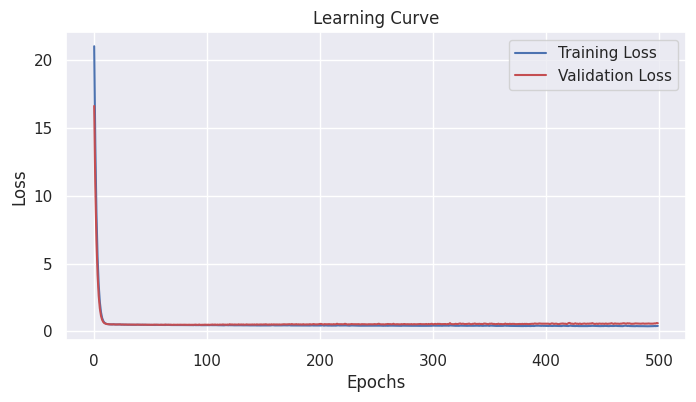

[0.8496683835983276, 72.0, 12.0, 27.0, 16.0, 0.7795275449752808, 0.8571428656578064, 0.8181818127632141, 0.8414918780326843, 0.9125487804412842]
16/16 [==============================] - 0s 2ms/step
Balanced Accuracy score on the test set for NN is: 0.74


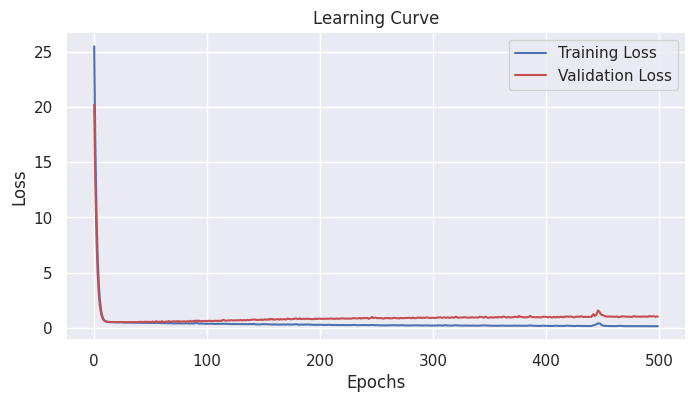

[1.0613126754760742, 76.0, 14.0, 25.0, 12.0, 0.7952755689620972, 0.8444444537162781, 0.8636363744735718, 0.7836538553237915, 0.858688473701477]
16/16 [==============================] - 0s 3ms/step
Balanced Accuracy score on the test set for NN is: 0.76


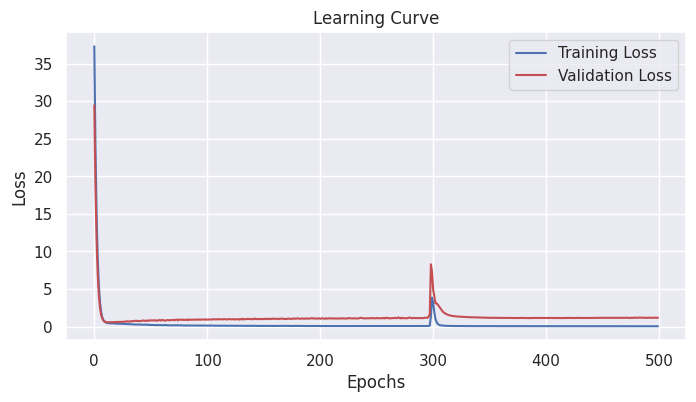

[1.0934969186782837, 70.0, 14.0, 25.0, 18.0, 0.748031497001648, 0.8333333134651184, 0.7954545617103577, 0.7827796936035156, 0.8647409677505493]
16/16 [==============================] - 0s 4ms/step
Balanced Accuracy score on the test set for NN is: 0.71


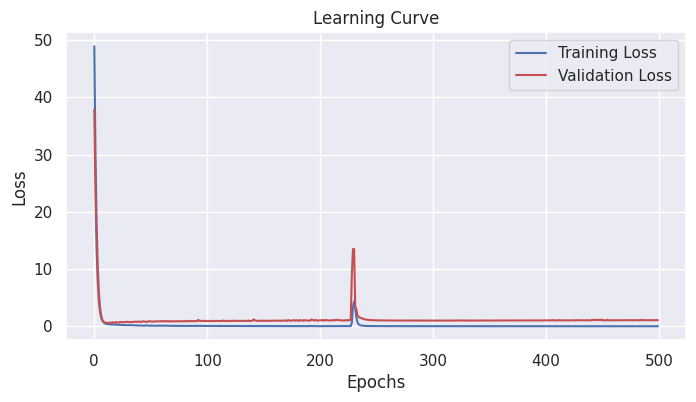

In [ ]:
for i in selected_features_[:4]:
  NN_function(i)

### KNN

In [ ]:
def KNN_function(selected_features, stand_X_train=stand_X_train, stand_y_train=stand_y_train,
                 stand_X_test=stand_X_test, stand_y_test=stand_y_test, name='KNN'):

  knn_classifier = KNeighborsClassifier(n_neighbors=5, metric='manhattan', algorithm='auto')

  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  scores = np.zeros(5)

  for i, (train_index, test_index) in enumerate(kf.split(stand_X_train[selected_features])):
      X_train_fk, X_test_fk = stand_X_train[selected_features].iloc[train_index], stand_X_train[selected_features].iloc[test_index]
      y_train_fk, y_test_fk = y_train.iloc[train_index], y_train.iloc[test_index]

      knn_classifier.fit(X_train_fk, y_train_fk)

      score = knn_classifier.score(X_test_fk, y_test_fk)
      scores[i] = score

  y_pred_test = knn_classifier.predict(stand_X_test[selected_features])
  y_pred_train = knn_classifier.predict(stand_X_train[selected_features])

  ba_score = balanced_accuracy_score(stand_y_test, y_pred_test)

  print("Balanced Accuracy score on the test set for KNNClassifier is: {:.2f}".format(ba_score))

  # results.loc[len(results)] = create_record(y_pred_train, y_pred_test, 'KNN')
  results.loc[len(results)] = create_record((y_pred_train>0.2), (y_pred_test>0.2), name, stand_y_test, stand_y_train, selected_features)

In [ ]:
for i in selected_features_[:4]:
  KNN_function(i)

Balanced Accuracy score on the test set for KNNClassifier is: 0.69
Balanced Accuracy score on the test set for KNNClassifier is: 0.70
Balanced Accuracy score on the test set for KNNClassifier is: 0.73
Balanced Accuracy score on the test set for KNNClassifier is: 0.71


In [ ]:
from sklearn.naive_bayes import GaussianNB

def GNB(selected_features, X_train=X_train, y_train=y_train,
                 X_test=X_test, y_test=y_test, name='GNB'):

  nb_classifier = GaussianNB()

  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  scores = np.zeros(5)

  for i, (train_index, test_index) in enumerate(kf.split(X_train[selected_features])):
      X_train_fk, X_test_fk = X_train[selected_features].iloc[train_index], X_train[selected_features].iloc[test_index]
      y_train_fk, y_test_fk = y_train.iloc[train_index], y_train.iloc[test_index]

      nb_classifier.fit(X_train_fk, y_train_fk)

      score = nb_classifier.score(X_test_fk, y_test_fk)
      scores[i] = score

  y_pred_test = nb_classifier.predict(X_test[selected_features])
  y_pred_train = nb_classifier.predict(X_train[selected_features])

  ba_score = balanced_accuracy_score(y_test, y_pred_test)

  print("balanced accuracy score on the test set for GNB Classifier is: {:.2f}".format(ba_score))

  results.loc[len(results)] = create_record((y_pred_train>0.2), (y_pred_test>0.2), name, y_test, y_train, selected_features)

In [ ]:
for i in selected_features_[:4]:
  GNB(i)

balanced accuracy score on the test set for GNB Classifier is: 0.76
balanced accuracy score on the test set for GNB Classifier is: 0.75
balanced accuracy score on the test set for GNB Classifier is: 0.71
balanced accuracy score on the test set for GNB Classifier is: 0.56


In [ ]:
results.to_csv('out.csv')

### Trying Oversampling

-----  20
[0.5797073841094971, 78.0, 12.0, 27.0, 10.0, 0.8267716765403748, 0.8666666746139526, 0.8863636255264282, 0.8145396113395691, 0.8561825156211853]
23/23 [==============================] - 0s 2ms/step
Balanced Accuracy score on the test set for NN is: 0.80


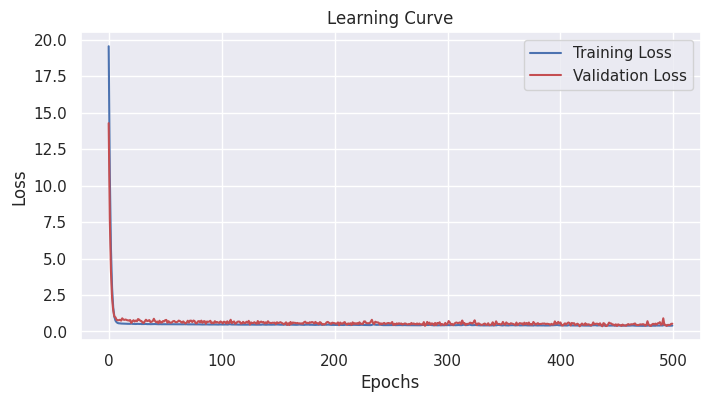

-----  50
[0.7800933122634888, 76.0, 10.0, 29.0, 12.0, 0.8267716765403748, 0.8837209343910217, 0.8636363744735718, 0.8471736311912537, 0.901642918586731]
23/23 [==============================] - 0s 3ms/step
Balanced Accuracy score on the test set for NN is: 0.80


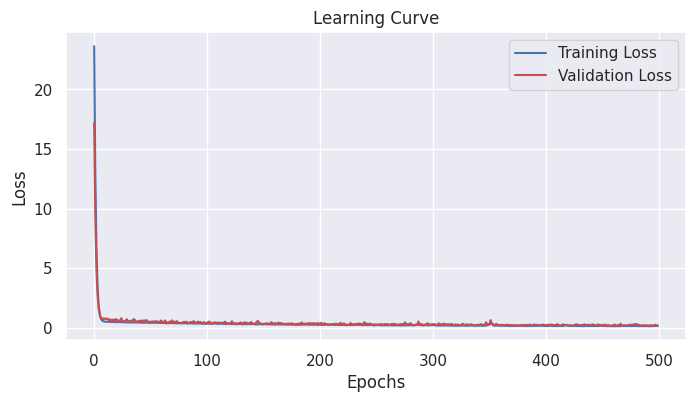

-----  150
[1.0850834846496582, 74.0, 13.0, 26.0, 14.0, 0.787401556968689, 0.8505747318267822, 0.8409090638160706, 0.820367157459259, 0.8924646377563477]
23/23 [==============================] - 0s 5ms/step
Balanced Accuracy score on the test set for NN is: 0.75


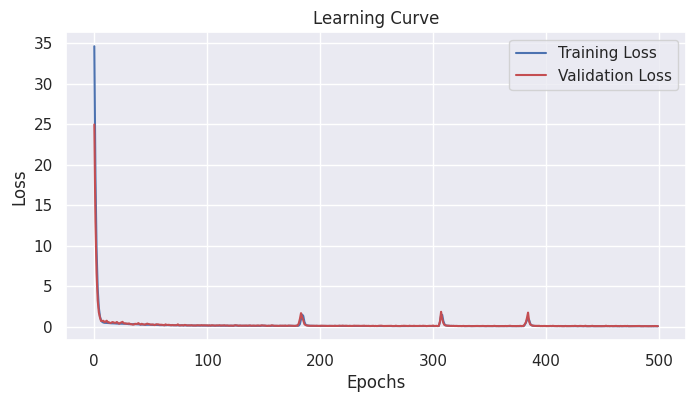

-----  300
[1.1120870113372803, 69.0, 13.0, 26.0, 19.0, 0.748031497001648, 0.8414633870124817, 0.7840909361839294, 0.7954546213150024, 0.8686540722846985]
23/23 [==============================] - 0s 3ms/step
Balanced Accuracy score on the test set for NN is: 0.71


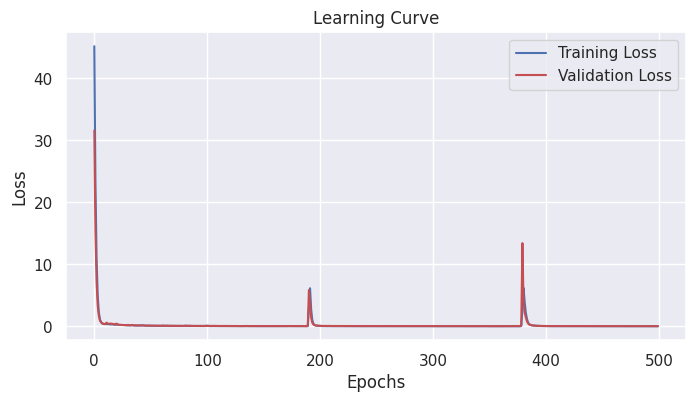

In [ ]:
NN_oversample_models = []
for i in selected_features_[:4]:
  print("----- ", len(i))
  NN_oversample_models.append(NN_function(i, stand_X_train=stand_X_train_sm, stand_y_train=stand_y_train_sm,
            stand_X_test=stand_X_test, stand_y_test=stand_y_test, name='NN_Oversampling'))

In [ ]:
XGB_models_oversample = []
for i in selected_features_[:4]:
  print("----- ", len(i))
  XGB_models_oversample.append(GradientBoostingClassifier_function(i, X_train=X_train_sm, y_train=y_train_sm,
            X_test=X_test, y_test=y_test, name='XGB_Oversampling'))

-----  20
BA score on the test set for GradientBoostingClassifier with 20 features is is: 0.77
-----  50
BA score on the test set for GradientBoostingClassifier with 50 features is is: 0.77
-----  150
BA score on the test set for GradientBoostingClassifier with 150 features is is: 0.78
-----  300
BA score on the test set for GradientBoostingClassifier with 300 features is is: 0.74


In [ ]:
import pickle

filename = 'NN_oversample_model.sav'
pickle.dump(NN_oversample_models[1], open(filename, 'wb'))

filename = 'XGB_oversample_model.sav'
pickle.dump(XGB_models_oversample[0], open(filename, 'wb'))